In [86]:
!pip install h3
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install joblib
!pip install xgboost
!pip install scikit-learn

In [87]:
# Complete implementation of Order Dispatching with RL



import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import h3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque
import time
import os

In [88]:
# turn off the warnings
import warnings
warnings.filterwarnings("ignore")
# Set the device to GPU if available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [89]:



# Load and prepare order data
orders_df = pd.read_csv("data/jan2_orders.csv")

# Print the original column names to verify
print("Original order column names:", orders_df.columns.tolist())



# Ensure necessary columns exist
required_columns = ['order_id', 'timestamp', 'h3_index', 'preparation_time']
missing_columns = [col for col in required_columns if col not in orders_df.columns]
if missing_columns:
    print(f"WARNING: Missing columns: {missing_columns}")
    # You might need to create these columns if they don't exist

# Rename columns only if the original columns exist
if 'order_id' in orders_df.columns:
    orders_df = orders_df.rename(columns={
        'order_id': 'Order_ID',
        'h3_index': 'Grid_ID',
        'timestamp': 'Timestamp',
        'preparation_time': 'Preparation_Time'
    })

# Sample 500 orders for testing
if len(orders_df) > 500:
    orders_df = orders_df.sample(100, random_state=42)
    print(f"Sampled 500 orders for testing from {len(orders_df)} total orders")
else:
    print(f"Using all {len(orders_df)} orders for testing")

# Add debug print to check data
print(f"Order data loaded with {len(orders_df)} rows")
# Convert timestamp string to datetime object
orders_df["Timestamp"] = pd.to_datetime(orders_df["Timestamp"])

# Initialize start time as 9 AM on Jan 2
START_TIME = pd.Timestamp("2025-01-02 09:00:00")

# Debug: Check min and max timestamps in data
print(f"Min timestamp in data: {orders_df['Timestamp'].min()}")
print(f"Max timestamp in data: {orders_df['Timestamp'].max()}")

# Ensure there are orders in the simulation time window (9am -10 pm)
simulation_end_time = START_TIME + timedelta(hours=13)
orders_in_window = len(orders_df[(orders_df["Timestamp"] >= START_TIME) & 
                               (orders_df["Timestamp"] < simulation_end_time)])
print(f"Orders in simulation time window ({START_TIME} - {simulation_end_time}): {orders_in_window}")

# If no orders in simulation window, adjust the time window or create synthetic orders
if orders_in_window == 0:
    print("WARNING: No orders in simulation time window. Creating synthetic orders...")
    # Create synthetic orders for testing
    synthetic_orders = []
    num_orders = 500
    for i in range(num_orders):
        order_time = START_TIME + timedelta(minutes=random.randint(0, 119))
        synthetic_orders.append({
            'Order_ID': f"synth_{i}",
            'Timestamp': order_time,
            'Grid_ID': random.choice(list(set(orders_df['Grid_ID'].tolist()[:100]))),
            'Preparation_Time': random.randint(5, 25)  # 5-25 minutes
        })
    orders_df = pd.DataFrame(synthetic_orders)
    print(f"Created {num_orders} synthetic orders")

# Filter orders starting from 9 AM
orders_df = orders_df[orders_df["Timestamp"] >= START_TIME]
print(f"Orders after filtering: {len(orders_df)}")
# Load courier data
couriers_df = pd.read_csv("data/jan1_trucks.csv")
# sample 50 couriers for testing
couriers_df = couriers_df.sample(100, random_state=42)

# Print the original column names to verify
print("Original courier column names:", couriers_df.columns.tolist())

Original order column names: ['order_id', 'h3_index', 'timestamp', 'preparation_time', 'time_bin']
Using all 174 orders for testing
Order data loaded with 174 rows
Min timestamp in data: 2025-01-02 09:03:26
Max timestamp in data: 2025-01-02 21:59:20
Orders in simulation time window (2025-01-02 09:00:00 - 2025-01-02 22:00:00): 174
Orders after filtering: 174
Original courier column names: ['truck_id', 'h3_index', 'latitude', 'longitude', 'capacity', 'speed', 'status']


In [90]:
# Define DQN model for RL agent
class ConvDQN(nn.Module):
    def __init__(self, courier_feature_size=3, hidden_size=64, max_couriers=100):
        super(ConvDQN, self).__init__()
        self.courier_feature_size = courier_feature_size
        self.max_couriers = max_couriers
        
        # Convolutional layer processes each courier's features as a unit
        self.conv = nn.Conv1d(1, 16, kernel_size=courier_feature_size, stride=courier_feature_size)
        
        # Fully connected layers
        self.fc1 = nn.Linear(1 + 16, hidden_size)  # Order feature + courier embeddings
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = None
        self.output_size = None
        self.hidden_size = hidden_size

    def init_output_layer(self, output_size):
        """Dynamically set the output layer size"""
        if self.output is None or self.output_size != output_size:
            # Create new output layer with the requested size
            self.output = nn.Linear(self.hidden_size, output_size)
            self.output_size = output_size

    def forward(self, x_order, x_couriers):
        batch_size = x_order.size(0)
        
        # Process courier features
        x_couriers = x_couriers.view(batch_size, 1, -1)
        courier_features = self.conv(x_couriers)
        
        # Global max pooling across courier embeddings
        courier_features = torch.max(courier_features, dim=2)[0]
        
        # Concatenate order feature with courier embeddings
        combined = torch.cat((x_order, courier_features), dim=1)
        
        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        
        # Output Q-values
        if self.output is not None:
            return self.output(x)
        else:
            raise ValueError("Output layer not initialized. Call init_output_layer first.")

    def get_state_dict_without_output(self):
        """Get state dict excluding the output layer"""
        state_dict = self.state_dict()
        return {k: v for k, v in state_dict.items() if 'output' not in k}


In [91]:
class DemandForecaster:
    """Optimized demand forecasting class with spatial and temporal features."""
    def __init__(self, historical_orders=None):
        self.model = None
        self.historical_orders = historical_orders
        self.prediction_cache = {}
        
        # Load the pre-trained model
        try:
            self.model = joblib.load("models/demand_forecast_xgb.joblib")
            print(f"✓ Loaded demand forecasting model from models/demand_forecast_xgb.joblib")
        except Exception as e:
            print(f"❌ Error loading demand forecast model: {e}")
            print("Using fallback prediction method")
        
        # Load feature columns
        try:
            feature_info = joblib.load("models/demand_forecast_features.joblib")
            self.feature_columns = feature_info['feature_columns']
            print(f"✓ Loaded feature columns: {self.feature_columns}")
        except Exception as e:
            print(f"❌ Error loading feature columns: {e}")
            self.feature_columns = []

    def predict_demand(self, grid_id, timestamp):
        """Predict demand for a specific grid and time."""
        # Check cache first
        cache_key = (grid_id, pd.Timestamp(timestamp).floor('15min'))
        if cache_key in self.prediction_cache:
            return self.prediction_cache[cache_key]
        
        # If model failed to load, use fallback prediction
        if self.model is None:
            prediction = self._fallback_prediction(grid_id, timestamp)
            self.prediction_cache[cache_key] = prediction
            return prediction
        
        try:
            # Get features
            time_features = self._get_time_features(timestamp)
            lag_features = self._get_lag_features(grid_id, timestamp)
            spatial_features = self._get_spatial_features(grid_id, timestamp)
            
            # Combine features
            features = {
                **time_features,
                **lag_features,
                **spatial_features
            }
            
            # Ensure feature order matches the model's expected input
            feature_vector = [features.get(col, 0) for col in self.feature_columns]
            
            # Make prediction
            prediction = self.model.predict([feature_vector])[0]
            
            # Ensure non-negative integer
            prediction = max(0, round(prediction))
            
            # Cache result
            self.prediction_cache[cache_key] = prediction
            
            return prediction
        except Exception as e:
            print(f"Error predicting demand for grid {grid_id}: {e}")
            prediction = self._fallback_prediction(grid_id, timestamp)
            self.prediction_cache[cache_key] = prediction
        return prediction
    
    def _fallback_prediction(self, grid_id, timestamp):
        """Fallback prediction based on historical averages."""
        if self.historical_orders is None:
            return 2  # Default fallback
        
        # Filter for this grid
        grid_orders = self.historical_orders[self.historical_orders['Grid_ID'] == grid_id]
        if grid_orders.empty:
            return 2  # Default fallback
        
        # Calculate average demand for the same hour of the day
        hour = pd.Timestamp(timestamp).hour
        avg_demand = grid_orders[pd.to_datetime(grid_orders['Timestamp']).dt.hour == hour].shape[0]
        return max(1, round(avg_demand / 7))  # Weekly average

    def _get_time_features(self, timestamp):
        """Extract time features from timestamp."""
        dt = pd.Timestamp(timestamp)
        hour = dt.hour
        day_of_week = dt.dayofweek
        is_weekend = 1 if day_of_week >= 5 else 0
        
        return {
            'hour': hour,
            'day_of_week': day_of_week,
            'is_weekend': is_weekend
        }
    
    def _get_lag_features(self, grid_id, timestamp):
        """Get lag features for a grid at a specific time."""
        if self.historical_orders is None:
            return {f'demand_lag_{i}': 0 for i in range(1, 5)}
        
        # Filter for this grid
        grid_orders = self.historical_orders[self.historical_orders['Grid_ID'] == grid_id].copy()
        if len(grid_orders) == 0:
            return {f'demand_lag_{i}': 0 for i in range(1, 5)}
        
        # Create time bins
        grid_orders['Time_Bin'] = pd.to_datetime(grid_orders['Timestamp']).dt.floor('15min')
        
        # Group by time bin and count
        demand_counts = grid_orders.groupby('Time_Bin').size().reset_index(name='count')
        demand_counts = demand_counts.sort_values('Time_Bin')
        
        # Get counts for previous time slots
        time_bin = pd.Timestamp(timestamp).floor('15min')
        lag_features = {}
        for i, lag in enumerate(range(15, 75, 15), 1):
            lag_features[f'demand_lag_{i}'] = self._get_count_at_time(demand_counts, time_bin - timedelta(minutes=lag))
        
        return lag_features
    
    def _get_count_at_time(self, demand_counts, time_bin):
        """Get order count for a specific time bin."""
        matches = demand_counts[demand_counts['Time_Bin'] == time_bin]
        if not matches.empty:
            return matches.iloc[0]['count']
        return 0
    
    def _get_spatial_features(self, grid_id, timestamp):
        """Incorporate demand from neighboring grids."""
        try:
            # Get neighboring grids using H3
            neighbors = h3.grid_ring(grid_id, 1)
            neighbors = [n for n in neighbors if n != grid_id]
            
            # Use cached predictions or fallback for neighbors
            neighbor_demand = 0
            for neighbor in neighbors:
                cache_key = (neighbor, pd.Timestamp(timestamp).floor('15min'))
                if cache_key in self.prediction_cache:
                    neighbor_demand += self.prediction_cache[cache_key]
                else:
                    # Use fallback instead of recursive call
                    neighbor_demand += self._fallback_prediction(neighbor, timestamp)
            
            # Average demand across neighbors
            neighbor_demand /= max(1, len(neighbors))
        except Exception as e:
            print(f"Error calculating spatial features for grid {grid_id}: {e}")
            neighbor_demand = 0
        
        return {'neighbor_demand': neighbor_demand}

In [92]:
# Function to initialize couriers dictionary
def initialize_couriers(couriers_df):
    couriers = {}
    for _, row in couriers_df.iterrows():
        courier_id = row["truck_id"]
        couriers[courier_id] = {
            "Truck_ID": courier_id,
            "Latitude": row["latitude"],
            "Longitude": row["longitude"],
            "Grid_ID": row["h3_index"],
            "Future_Grid": row["h3_index"],
            "Capacity": row["capacity"],
            "Speed": row["speed"],
            "Status": "available",
            "Expected_Idle_Time": 0,  # In seconds
            "Total_Idle_Time": 0,     # In seconds
            "Postpone_Count": 0       # Track how many times an order has been postponed
        }
    return couriers

# Initialize couriers
couriers = initialize_couriers(couriers_df)
print(f"Initialized {len(couriers)} couriers")

# Load demand prediction data if available
try:
    demand_df = pd.read_csv("data/demand_predictions.csv")
    demand_df["time_bin"] = pd.to_datetime(demand_df["time_bin"])
except:
    # Create empty demand predictions if file not available
    demand_df = pd.DataFrame(columns=["h3_index", "time_bin", "predicted_demand"])


# Add this after the imports but before OrderDispatchEnv class definition
import joblib
from datetime import datetime, timedelta

# Define RL Agent class - UPDATED without normalization
class RLAgent:
    def __init__(self, courier_feature_size=3, epsilon_decay=0.99, epsilon_min=0.05):
        self.courier_feature_size = courier_feature_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = 0.001
        self.update_target_freq = 10
        self.model = ConvDQN(courier_feature_size)
        self.target_model = ConvDQN(courier_feature_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.batch_size = 32
        self.episode_count = 0
        
        # Initialize both models with the same weights
        self.update_target_network()
        
        print("Networks initialized")

    def update_target_network(self):
        """Copy weights from main model to target model with proper handling of output layer"""
        # Copy all shared layers (excluding the output layer)
        shared_state_dict = self.model.get_state_dict_without_output()
        
        # Load the shared layers into the target model
        target_state_dict = self.target_model.state_dict()
        target_state_dict.update({k: v for k, v in shared_state_dict.items()})
        
        # Handle the output layer separately if it exists
        if self.model.output is not None and self.target_model.output is not None:
            if self.model.output_size == self.target_model.output_size:
                # Only copy output layer if sizes match
                for param_name in ['output.weight', 'output.bias']:
                    if param_name in self.model.state_dict():
                        target_state_dict[param_name] = self.model.state_dict()[param_name]
        
        # Load the updated state dictionary
        self.target_model.load_state_dict(target_state_dict, strict=False)
        
        # Ensure both models have the same output size
        if self.model.output_size is not None:
            self.target_model.init_output_layer(self.model.output_size)
            
        print(f"Target network updated, output sizes: main={self.model.output_size}, target={self.target_model.output_size}")
        
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory with size check"""
        if len(self.memory) >= self.memory.maxlen - 1:
            # If memory is nearly full, remove some old experiences
            self.memory = deque(list(self.memory)[-int(self.memory.maxlen/2):], maxlen=self.memory.maxlen)
        
        self.memory.append((state, action, reward, next_state, done))
            
    def prepare_input(self, state):
        """Prepare state for neural network input with fixed-size tensors"""
        if state is None:
            return None
                
        # Extract order feature (prep time) in seconds
        order_feature = torch.tensor([[state["Raw_Prep_Time"]]], dtype=torch.float32)
        
        # Extract courier features with a fixed maximum size
        courier_features = []
        valid_actions = state["Valid_Actions"]
        max_couriers = 100  # Set a reasonable maximum number of couriers to process
        
        for i, action in enumerate(valid_actions):
            if i >= max_couriers:
                break  # Limit the number of couriers to prevent tensor size explosion
                
            if action == "postpone":
                # For postpone action, add a dummy courier with zeros
                courier_features.extend([0] * self.courier_feature_size)
            else:
                # Extract real courier features
                courier_id = action
                courier = state["Couriers"].get(courier_id, {})
                
                # Raw features without normalization
                idle_time = courier.get("Expected_Idle_Time", 0)  # seconds
                distance = state["Distances"].get(courier_id, 20)  # grid units
                supply_gap = state["Supply_Gaps"].get(courier_id, 0)  # raw supply-demand gap
                
                courier_features.extend([idle_time, distance, supply_gap])
        
        # Pad or truncate to ensure fixed size
        target_size = max_couriers * self.courier_feature_size
        if len(courier_features) < target_size:
            courier_features.extend([0] * (target_size - len(courier_features)))
        elif len(courier_features) > target_size:
            courier_features = courier_features[:target_size]
            
        courier_features_tensor = torch.tensor([courier_features], dtype=torch.float32)
        
        return order_feature, courier_features_tensor  

    def act(self, state):
        """Choose action based on epsilon-greedy policy"""
        if state is None:
            return 0
            
        valid_actions = state["Valid_Actions"]
        
        # Check if there are any valid actions
        if not valid_actions:
            return 0
            
        # With probability epsilon, choose a random action
        if random.random() < self.epsilon:
            return random.randrange(len(valid_actions))
            
        # Otherwise, choose the action with the highest Q-value
        inputs = self.prepare_input(state)
        if inputs is None:
            return random.randrange(len(valid_actions))
            
        order_feature, courier_features = inputs
        
        # Ensure output layer matches the number of valid actions
        # Update output layer for both model and target model to match action space
        self.model.init_output_layer(len(valid_actions))
        self.target_model.init_output_layer(len(valid_actions))
        
        # Get Q-values for all actions
        with torch.no_grad():
            q_values = self.model(order_feature, courier_features)
            
        # Choose action with highest Q-value
        return torch.argmax(q_values).item()
    
    def replay(self, batch_size):
        """Train the model on a batch of experiences"""
        if len(self.memory) < batch_size:
            return
            
        try:
            # Sample a batch of experiences
            minibatch = random.sample(self.memory, batch_size)
            
            for state, action, reward, next_state, done in minibatch:
                 # Skip if state is invalid
                if state is None or "Valid_Actions" not in state or not state["Valid_Actions"]:
                    continue
                
                inputs = self.prepare_input(state)
                if inputs is None:
                    continue
                    
                order_feature, courier_features = inputs
                
                # Set output layer size for current state
                num_actions = len(state["Valid_Actions"])
                
                # Get current Q-values
                self.model.init_output_layer(len(state["Valid_Actions"]))
                
                # get current Q-values
                current_q = self.model(order_feature, courier_features)
                
                # Calculate target Q-values
                target_q = current_q.clone()
                
                if done:
                    target_q[0][action] = reward
                else:
                    if next_state is None:
                        continue
                    
                     # Skip if next_state is invalid
                    if next_state is None or "Valid_Actions" not in next_state or not next_state["Valid_Actions"]:
                        continue
                        
                    next_inputs = self.prepare_input(next_state)
                    if next_inputs is None:
                        continue
                        
                    next_order_feature, next_courier_features = next_inputs
                    
                    # Set output layer size for next state
                    next_num_actions = len(next_state["Valid_Actions"])
                    self.target_model.init_output_layer(next_num_actions)
                    
                    # Use target network for next state Q-values
                    with torch.no_grad():
                        next_q = self.target_model(next_order_feature, next_courier_features)
                        max_next_q = torch.max(next_q).item()
                    
                    target_q[0][action] = reward + self.gamma * max_next_q
                
                # Train the model
                self.optimizer.zero_grad()
                loss = self.loss_fn(current_q, target_q)
                loss.backward()
                self.optimizer.step()
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        except RuntimeError as e:
            print(f"Error during replay: {e}")
            if len(self.memory) > batch_size * 2:
                self.memory = deque(list(self.memory)[-batch_size:], maxlen=self.memory.maxlen)
            
    
    def save_model(self, file_path):
        """Save model weights to file"""
        torch.save(self.model.state_dict(), file_path)
        
    def load_model(self, file_path):
        """Load model weights from file"""
        self.model.load_state_dict(torch.load(file_path))
        self.target_model.load_state_dict(torch.load(file_path))

# Define RL Environment Class
class OrderDispatchEnv:
    def __init__(self, orders, couriers):
        # Store data
        self.orders = orders
        self.orders["Timestamp"] = pd.to_datetime(self.orders["Timestamp"])
        self.couriers = couriers
        # Time and simulation parameters
        self.START_TIME = START_TIME
        self.current_time = self.START_TIME
        self.TIME_STEP = 60  # 1 minute in seconds
        self.simulation_steps = 0
        self.max_simulation_steps = 13 * 60  # 13 hours = 780 minutes
        self.postponed_this_step = set()  # Track orders postponed in current time step
        
        # Order queue and tracking
        self.order_queue = []
        self.processed_order_ids = set()
        self.order_postpone_counts = {}   # Track postpone count for each order
        self.order_entry_times = {}       # Track when each order first entered system
        self.order_wait_times = {}        # Track wait times for post-analysis
        # Initialize demand forecaster with historical orders
        self.forecaster = DemandForecaster(orders)
        # Track actual demands for evaluation
        self.actual_demands = {}  # Maps (grid_id, time_bin) to actual order count
        # Courier parameters
        self.AVG_SPEED_KMH = 22.0  # Average courier speed in km/h
        # Metrics
        self.total_rewards = 0
        self.assigned_orders = 0
        self.postponed_orders = 0
        self.removed_orders = 0
        self.expired_orders = 0           # Orders removed due to long wait time
        self.total_delivery_time = 0
        self.order_delays = []
        self.time_gaps = []
        self.courier_utilization = {courier_id: 0 for courier_id in self.couriers}
        self.assignment_log = []          # Log of order assignments
        # Cache for expensive calculations
        self.distance_cache = {}
        self.supply_demand_cache = {}
        
        # Constants for reward calculation
        self.REWARD_DELIVERY = 120
        self.PENALTY_POSITIVE_TIME_GAP = -5  # Per minute courier arrives late
        self.PENALTY_NEGATIVE_TIME_GAP = -1  # Per minute courier waits
        self.PENALTY_TRAVEL_DISTANCE = -3    # Per grid unit of travel
        self.REWARD_REBALANCING = 5          # For picking from over-supplied areas
        self.PENALTY_POSTPONE = -10          # For postponing an order
        self.PENALTY_OVERDUE = -100          # For removing an overdue order
        self.PENALTY_LONG_WAIT = -200        # Penalty for orders waiting too long in queue
        
        # Time thresholds
        self.MAX_ORDER_WAIT_TIME = 600      # 10 minutes in seconds
        
        # Load demand predictions if available
        self.demand_predictions = demand_df
    
    # runs for every new episode
    def reset(self):
        """Reset environment for a new episode"""
        # Reset time
        self.current_time = self.START_TIME
        self.simulation_steps = 0
        
        # Reset order queue and tracking
        self.order_queue = []
        self.processed_order_ids = set()
        self.order_postpone_counts = {}
        self.order_entry_times = {}
        self.order_wait_times = {}
        self.assignment_log = []
        
        # Reset metrics
        self.total_rewards = 0
        self.assigned_orders = 0
        self.postponed_orders = 0
        self.removed_orders = 0
        self.expired_orders = 0
        self.total_delivery_time = 0
        self.order_delays = []
        self.time_gaps = []
        self.courier_utilization = {courier_id: 0 for courier_id in self.couriers}
        
        # Reset courier states
        for courier_id in self.couriers:
            self.couriers[courier_id]["Status"] = "available"
            self.couriers[courier_id]["Expected_Idle_Time"] = 0
            self.couriers[courier_id]["Total_Idle_Time"] = 0
            self.couriers[courier_id]["Future_Grid"] = self.couriers[courier_id]["Grid_ID"]
            self.couriers[courier_id]["Postpone_Count"] = 0
        
        # Reset caches
        self.distance_cache = {}
        self.supply_demand_cache = {}
        
        # Count orders in simulation time range
        simulation_end_time = self.START_TIME + timedelta(minutes=self.max_simulation_steps)
        orders_in_range = len(self.orders[(self.orders["Timestamp"] >= self.START_TIME) & 
                                        (self.orders["Timestamp"] < simulation_end_time)])
        print(f"Total orders in simulation time range: {orders_in_range}")
        
        # Initialize order queue with orders available at start time
        self.process_new_orders()
        
        # Log how many orders are in queue by preparation time buckets
        if self.order_queue:
            prep_times = []
            for order_entry in self.order_queue:
                order_id = order_entry["Order_ID"]
                prep_time = self.orders.loc[self.orders["Order_ID"] == order_id, "Preparation_Time"].values[0]
                prep_times.append(prep_time)
            
            # Create buckets
            buckets = {'0-10min': 0, '10-20min': 0, '20-30min': 0, '30+min': 0}
            for prep in prep_times:
                if prep <= 10:
                    buckets['0-10min'] += 1
                elif prep <= 20:
                    buckets['10-20min'] += 1
                elif prep <= 30:
                    buckets['20-30min'] += 1
                else:
                    buckets['30+min'] += 1
            
            print("Orders by preparation time:")
            for bucket, count in buckets.items():
                print(f"  {bucket}: {count} orders")
        
        # Log courier status at start
        available_couriers = len([c for c in self.couriers.values() if c["Status"] == "available"])
        busy_couriers = len([c for c in self.couriers.values() if c["Status"] == "busy"])
        print(f"Courier status at start: {available_couriers} available, {busy_couriers} busy")
            
        # If there are orders in the queue, get the state for the first one
        if self.order_queue:
            return self.get_state()
        else:
            print("WARNING: No orders in queue after reset")
        
        return None

    def process_new_orders(self):
        """Add new orders that arrived in this time step to the queue"""
        # Find orders that arrived in this time window
        time_window_end = self.current_time + timedelta(seconds=self.TIME_STEP)
        
        # Debug log every 30 minutes
        if self.simulation_steps % 30 == 0:
            orders_count = len(self.orders[(self.orders["Timestamp"] >= self.current_time) & 
                                        (self.orders["Timestamp"] < self.current_time + timedelta(minutes=30))])
            print(f"DEBUG: Next 30 minutes have {orders_count} orders scheduled")
        
        # Filter orders in the current time window
        new_orders = self.orders[
            (self.orders["Timestamp"] >= self.current_time) & 
            (self.orders["Timestamp"] < time_window_end)
        ]
        
        # Add new orders to queue
        count = 0
        for _, order in new_orders.iterrows():
            order_id = order["Order_ID"]
            # order is not already in queue or processed 
            if order_id not in self.processed_order_ids and order_id not in [o["Order_ID"] for o in self.order_queue]:
                entry_time = self.current_time
                queue_entry = {
                    "Order_ID": order_id,
                    "Entry_Time": entry_time, # should enevr change when postponong also
                    "Last_Postponed": None,
                    "Original_Timestamp": order["Timestamp"]
                }
                self.order_queue.append(queue_entry)
                # Record entry time for new orders
                self.order_entry_times[order_id] = pd.Timestamp(entry_time)
                # Log the order entry
                print(f"Added order {order_id} to queue at time {entry_time.strftime('%H:%M:%S')}")
                print(f"DEBUG: Stored entry time type: {type(self.order_entry_times[order_id])}")
                # Initialize postpone count
                self.order_postpone_counts[order_id] = 0
                count += 1 # increment count of new orders added into queue
                grid_id = order["Grid_ID"]
                time_bin = pd.Timestamp(order["Timestamp"]).floor('15min')
                actual_key = (grid_id, time_bin)
                
                if actual_key in self.actual_demands:
                    self.actual_demands[actual_key] += 1
                else:
                    self.actual_demands[actual_key] = 1
        
        if count > 0:
            print(f"Added {count} new orders to queue at time {self.current_time.strftime('%H:%M:%S')}")
            
        # Check for orders that have been waiting too long in the queue
        self.check_queue_timeouts()
            
        # Sort order queue by preparation time (ascending) - most urgent first
        if self.order_queue:
            try:
                self.order_queue.sort(key=lambda order_entry: 
                    self.orders.loc[self.orders["Order_ID"] == order_entry["Order_ID"], "Preparation_Time"].values[0]) # Sort by prep time
            except Exception as e:
                print(f"Error sorting order queue: {e}")
                # If sorting fails, just continue with unsorted queue
                pass

    def check_queue_timeouts(self):
        """Check for orders that have been waiting too long in the queue and remove them"""
        if not self.order_queue:
            return
        print("Checking for orders that have been waiting too long in the queue...")
        # Check each order in the queue for timeout
        orders_to_remove = []
        for i, order_entry in enumerate(self.order_queue):
            order_id = order_entry["Order_ID"]
            entry_time = order_entry["Entry_Time"]
            wait_time = (self.current_time - entry_time).total_seconds()
            print(f"chk timeouts : Order {order_id} has been waiting for {wait_time/60:.1f} minutes")
            
            # If order has been waiting too long (>10 minutes), mark for removal
            if wait_time > self.MAX_ORDER_WAIT_TIME:
                print(f"⚠️ Order {order_id} has been waiting more than thres - ({wait_time/60:.1f} minutes)")
                orders_to_remove.append((i, order_id, wait_time))
        
        # Remove orders from back to front to maintain correct indices
        for idx, order_id, wait_time in reversed(orders_to_remove):
            print(f"⚠️ ORDER EXPIRED: Order {order_id} removed after waiting {wait_time/60:.1f} minutes in queue!")
            self.order_queue.pop(idx)
            self.processed_order_ids.add(order_id)
            self.expired_orders += 1
            self.removed_orders += 1
            self.order_wait_times[order_id] = wait_time
            self.total_rewards += self.PENALTY_LONG_WAIT  # Apply penalty for expired orders

    def seconds_to_minutes(self, seconds):
        """Convert seconds to minutes"""
        return seconds / 60.0
    
    def minutes_to_seconds(self, minutes):
        """Convert minutes to seconds"""
        return minutes * 60.0
    
    def grid_units_to_km(self, grid_units):
        """
        Convert H3 grid units to kilometers based on resolution 8 hexagons
        At resolution 8:
        - Distance from center to vertex ≈ 0.55 km
        - When traveling between adjacent hexagons:
        - First hop: 0.55 (center to edge) + 0.55 (edge to center) = 1.1 km
        - Additional hops: 0.55*2 = 1.1 km per hop
        """
        if grid_units == 0:
            return 0
        elif grid_units == 1:
            return 0.55 + 0.55  # Center to edge + edge to center = 1.1 km
        else:
            # First hop (1.1 km) + additional hops
            return (0.55 + 0.55) + ((grid_units - 1) * 0.55 * 2)
    
    def km_to_grid_units(self, km):
        """Convert kilometers to H3 grid units"""
        return max(1, round(km / 0.15))
    
    def calculate_travel_time(self, distance_km, speed_kmh=None):
        """Calculate travel time in seconds based on distance and speed"""
        if speed_kmh <= 0:
            speed_kmh = self.AVG_SPEED_KMH
        
        hours = distance_km / speed_kmh
        return hours * 3600  # Convert hours to seconds
    
    def estimate_grid_distance(self, grid1, grid2):
        """Calculate H3 grid distance with caching"""
        # Check cache first
        cache_key = (grid1, grid2) if grid1 < grid2 else (grid2, grid1)
        if cache_key in self.distance_cache:
            return self.distance_cache[cache_key]
        
        # If grids are identical, distance is 0
        if grid1 == grid2:
            self.distance_cache[cache_key] = 0
            return 0
        
        try:
            # Calculate H3 grid distance
            distance = h3.grid_distance(grid1, grid2)
            # Cap at a reasonable maximum
            distance = min(20, distance)
        except Exception:
            # Fallback if H3 calculation fails
            common_prefix_len = 0
            grid1_str, grid2_str = str(grid1), str(grid2)
            for i in range(min(len(grid1_str), len(grid2_str))):
                if grid1_str[i] == grid2_str[i]:
                    common_prefix_len += 1
                else:
                    break
            
            # Estimate distance based on common prefix
            distance = max(1, min(20, 15 - common_prefix_len))
        
        # Cache and return
        self.distance_cache[cache_key] = distance
        return distance
    
    def get_supply_demand_gap(self, grid):
        """Calculate supply-demand gap using demand forecasting"""
        # Round time to nearest 15-minute bin for forecasting
        current_bin = self.current_time.floor('15min')
        forecast_bin = current_bin + timedelta(minutes=15)  # Look ahead 15 minutes
        
        # Create cache key
        cache_key = (grid, forecast_bin)
        if cache_key in self.supply_demand_cache:
            return self.supply_demand_cache[cache_key]
        
        # Count available couriers in this grid
        available_couriers = 0
        for c in self.couriers.values():
            if c["Future_Grid"] == grid and c["Expected_Idle_Time"] <= 0:
                available_couriers += 1
        
        # Get demand forecast for next 15 minutes
        if hasattr(self, 'forecaster'):
            predicted_demand = self.forecaster.predict_demand(grid, forecast_bin)
            
            # Track forecast bin for later comparing with actual demand
            actual_key = (grid, forecast_bin)
            if actual_key not in self.actual_demands:
                self.actual_demands[actual_key] = 0
                
            # Log predictions occasionally (5% chance) or for high demand
            if random.random() < 0.05 or predicted_demand >= 3:
                print(f"🔮 Demand forecast for grid {grid}: {predicted_demand} orders at {forecast_bin.strftime('%H:%M')}")
        else:
            # Default if no forecaster available
            predicted_demand = 2
        
        # Calculate supply-demand gap
        gap = available_couriers - predicted_demand
        
        # Cache and return
        self.supply_demand_cache[cache_key] = gap
        return gap
    
    # per order
    def get_state(self):
        """Generate state representation for current order"""
        if not self.order_queue:
            return None
        # Skip orders that were postponed in the current time step
        for i, order_entry in enumerate(self.order_queue):
            order_id = order_entry["Order_ID"]
            if order_id not in self.postponed_this_step:
                break # Found an order that wasn't postponed in this time step
        else:
            return None # All orders were postponed in this time step, wait for next time step
        
        # If the first order was postponed this step, rearrange the queue
        if i > 0:
            order_entry = self.order_queue.pop(i) # Move the first non-postponed order to the front
            self.order_queue.insert(0, order_entry)
        
        # Get the first order in the queue (most urgent)
        order_entry = self.order_queue[0]
        order_id = order_entry["Order_ID"]
        
        # Get the order from the dataframe
        order_rows = self.orders[self.orders["Order_ID"] == order_id]
        if len(order_rows) == 0:
            # Order not found, remove from queue
            self.order_queue.pop(0)
            return None
            
        order = order_rows.iloc[0] # Get the first row
        order["Timestamp"] = pd.to_datetime(order["Timestamp"]) # 
        
        # Calculate how much time until the order is ready
        # Preparation time is in minutes, convert to seconds
        prep_time_seconds = self.minutes_to_seconds(order["Preparation_Time"])
        
        # Calculate time since order was placed
        time_diff = (self.current_time - order["Timestamp"]).total_seconds()

        if time_diff < 0:
            # This is a future order (hasn't been placed yet)
            # Use a different variable to track this instead of modifying time_since_order
            time_since_order = 0  # The order is just being placed now
            is_future_order = True
            time_until_placement = abs(time_diff)
        else:
            # The order has already been placed
            time_since_order = time_diff
            is_future_order = False
            time_until_placement = 0

        # Use time_since_order for all your regular calculations
        # For preparation time, account for future orders specially
        if is_future_order:
            # For future orders, prep time hasn't started counting down yet
            raw_prep_time = prep_time_seconds + time_until_placement
        else:
            # For already placed orders, use your existing logic
            raw_prep_time = prep_time_seconds - time_since_order
        
        # Get valid actions (available couriers and postpone)
        valid_actions = []
        available_couriers = {}
        
        for courier_id, courier in self.couriers.items():
            if courier["Status"] == "available" and courier["Expected_Idle_Time"] <= 0:
                valid_actions.append(courier_id)
                available_couriers[courier_id] = courier
        
        # Add postpone action
        valid_actions.append("postpone")
        
        # Calculate distances between order and couriers
        distances = {}
        for courier_id in valid_actions:
            if courier_id != "postpone":
                distances[courier_id] = self.estimate_grid_distance(
                    self.couriers[courier_id]["Future_Grid"], 
                    order["Grid_ID"]
                )
        
        # Calculate supply-demand gaps
        supply_gaps = {}
        for courier_id in valid_actions:
            if courier_id != "postpone":
                supply_gaps[courier_id] = self.get_supply_demand_gap(
                    self.couriers[courier_id]["Future_Grid"]
                )
        
        # Check if order has been postponed too many times or is overdue
        postpone_count = self.order_postpone_counts.get(order_id, 0)
        # Build the state dictionary
        state = {
            "Order_ID": order_id,
            "Grid_ID": order["Grid_ID"],
            "Raw_Prep_Time": raw_prep_time,  # in seconds
            "Prep_Time_Minutes": raw_prep_time / 60.0,  # in minutes for human readability
            "Valid_Actions": valid_actions,
            "Num_Valid_Actions": len(valid_actions),
            "Couriers": available_couriers,
            "Distances": distances,
            "Supply_Gaps": supply_gaps,
            "Postpone_Count": postpone_count,
            # "Time_In_System": time_in_system
        }
        return state
    
    def step(self, action_idx):
        """Take action and return next state, reward, done flag"""
        if not self.order_queue:
            return None, 0, True
        
        # Get current state and order
        state = self.get_state()
        if state is None:
            return None, 0, True
            
        valid_actions = state["Valid_Actions"]
        order_entry = self.order_queue[0]
        order_id = order_entry["Order_ID"]
        
        # Check if valid actions list is empty (should never happen as postpone is always an option)
        if not valid_actions:
            return None, 0, True
            
        # Check for invalid action index
        if action_idx >= len(valid_actions):
            return state, -100, False
            
        action = valid_actions[action_idx]
        order = self.orders[self.orders["Order_ID"] == order_id].iloc[0]
        
        # Process action
        if action == "postpone":
            # Postpone the order
            self.postponed_orders += 1
            self.postponed_this_step.add(order_id)  # Track postponed orders in this step
            # Update postpone count for this order
            postpone_count = self.order_postpone_counts.get(order_id, 0) + 1
            self.order_postpone_counts[order_id] = postpone_count
            original_entry_time = self.order_entry_times[order_id]
            order_entry = self.order_queue.pop(0)
            order_entry["Last_Postponed"] = self.current_time
            self.order_queue.append(order_entry)
            
            self.order_entry_times[order_id] = original_entry_time # force entry time to be same as original entry time
            time_since_order = (self.current_time - order["Timestamp"]).total_seconds()
            # Check if order has been in system too long (>10 minutes)
            if postpone_count >= (10*60/self.TIME_STEP) or time_since_order > self.MAX_ORDER_WAIT_TIME:
                # Order is overdue, remove from system with large penalty
                reward = self.PENALTY_OVERDUE
                self.removed_orders += 1
                self.order_queue.pop(0)
                self.processed_order_ids.add(order_id)
                
                print(f"⚠️ ORDER OVERDUE: Order {order_id} removed after {time_since_order/60:.1f} minutes order made, postponed {postpone_count} times")
            else:
                # Just postpone the order with standard penalty
                reward = self.PENALTY_POSTPONE
                
                # Move order to end of queue with updated timestamp
                order_entry = self.order_queue.pop(0)
                order_entry["Last_Postponed"] = self.current_time
                self.order_queue.append(order_entry)
                
                if postpone_count % 3 == 0 or postpone_count == 1:  # Log first postponement and every 3rd
                    print(f"ℹ️ POSTPONED: Order {order_id} postponed {postpone_count} times, current wait time: {time_since_order/60:.1f} min")
    
        else:
            # Assign order to courier
            courier_id = action
            courier = self.couriers[courier_id]
            
            # Get distance in grid units
            pickup_distance_grid_units = self.estimate_grid_distance(courier["Future_Grid"], order["Grid_ID"])
            
            # Convert to km for travel time calculation
            pickup_distance_km = self.grid_units_to_km(pickup_distance_grid_units)
            
            # Calculate travel time in seconds
            courier_speed = courier.get("Speed", self.AVG_SPEED_KMH)
            travel_time_seconds = self.calculate_travel_time(pickup_distance_km, courier_speed)
            
            # Get preparation time in seconds
            prep_time_seconds = self.minutes_to_seconds(order["Preparation_Time"])
            
            # Calculate time since order was placed
            time_since_order = (self.current_time - order["Timestamp"]).total_seconds()
            
            # Remaining preparation time
            remaining_prep_time = max(0, prep_time_seconds - time_since_order)
            
            # In step method
            print(f"  - Preparation time: {prep_time_seconds/60:.1f} min, remaining: {remaining_prep_time/60:.1f} min")
            print(f"  - Travel time: {travel_time_seconds/60:.1f} min, Distance: {pickup_distance_km:.2f} km")
            # Time gap in seconds (negative means courier waits, positive means food waits)
            time_gap_seconds = travel_time_seconds - remaining_prep_time
            
            # Convert to minutes for reward calculation as per paper
            time_gap_minutes = self.seconds_to_minutes(time_gap_seconds)
            
            # Record time gap
            self.time_gaps.append(time_gap_seconds)
            
            # Calculate reward
            reward = self.REWARD_DELIVERY  # Base reward for delivery
            
            # With this:
            system_minutes = time_since_order
            queue_penalty = -2 * system_minutes
            reward += queue_penalty
            
            # Log the assignment details
            print(f"✅ ASSIGNED: Order {order_id} to courier {courier_id} after {time_since_order/60:.1f} min order placed")
            self.assignment_log.append({
                "Order_ID": order_id,
                "Courier_ID": courier_id,
                "Time_In_System": time_since_order,
                "Timestamp": self.current_time
            })
            
            # Add debug log for reward calculation for every assigned order
            print(f"  - Order wait time: {time_since_order:.1f} min, penalty: {queue_penalty:.2f}")
            print(f"  - Pickup distance: {pickup_distance_grid_units} grid units, travel time: {travel_time_seconds/60:.1f} min")
            
            # Time gap penalty/reward
            if time_gap_minutes > 0:  # Courier arrives after food ready (food waits)
                time_gap_penalty = self.PENALTY_POSITIVE_TIME_GAP * time_gap_minutes
                reward += time_gap_penalty
                print(f"  - Food will wait: {time_gap_minutes:.1f} min, penalty: {time_gap_penalty:.2f}")
            else:  # Courier waits for food
                wait_time_penalty = self.PENALTY_NEGATIVE_TIME_GAP * abs(time_gap_minutes)
                reward += wait_time_penalty
                print(f"  - Courier will wait: {abs(time_gap_minutes):.1f} min, penalty: {wait_time_penalty:.2f}")
            
            # Distance penalty
            distance_penalty = self.PENALTY_TRAVEL_DISTANCE * pickup_distance_grid_units
            reward += distance_penalty
            
            # Supply-demand balancing with improved forecasting
            current_grid = courier["Future_Grid"]  # Courier's current location
            dest_grid = order["Grid_ID"]           # Destination grid

            # Get supply-demand gap at current location
            current_supply_gap = self.get_supply_demand_gap(current_grid)

            # Get future demand prediction for destination
            future_time = self.current_time + timedelta(minutes=30)  # Look 30 minutes ahead
            if hasattr(self, 'forecaster'):
                future_demand = self.forecaster.predict_demand(dest_grid, future_time)
                
                # Look at adjacent grids too for a more comprehensive view
                try:
                    adjacent_grids = h3.grid_ring(dest_grid, 1)
                    adjacent_demand = sum(self.forecaster.predict_demand(g, future_time) 
                                        for g in adjacent_grids if g != dest_grid) / max(1, len(adjacent_grids) - 1)
                except:
                    adjacent_demand = 0
            else:
                future_demand = 2  # Default assumption
                adjacent_demand = 0

            # Calculate rebalancing reward based on forecasted demand
            if current_supply_gap > 1:  # Too many couriers at current location
                # Reward for leaving oversupplied area
                rebalancing_reward = self.REWARD_REBALANCING
            elif current_supply_gap < -1:  # Significant undersupply
                # Higher penalty for leaving undersupplied area
                rebalancing_reward = self.REWARD_REBALANCING * -2
            else:  # Balanced supply
                rebalancing_reward = 0

            # Add bonus for moving to high future demand areas
            if future_demand >= 3:
                # Bonus proportional to predicted demand
                demand_bonus = min(future_demand, 8) * 0.8  # Cap to avoid excessive values
                rebalancing_reward += demand_bonus
                
                print(f"  - Moving to high demand area bonus: +{demand_bonus:.2f} (forecast: {future_demand} orders at {future_time.strftime('%H:%M')})")

            reward += rebalancing_reward
            print(f"  - Rebalancing reward: {rebalancing_reward:.2f} (supply gap: {current_supply_gap}, future demand: {future_demand})")
            
            # Total reward summary
            print(f"- Total reward: {reward:.2f}")
            
            # Update courier status
            courier["Status"] = "busy"
            
            # Update courier's expected idle time
            delivery_distance_km = pickup_distance_km 
            delivery_time_seconds = self.calculate_travel_time(delivery_distance_km, courier_speed)
            # Total time until courier is available again (in seconds)
            # If courier arrives before food is ready, they wait at restaurant
            time_until_idle = max(travel_time_seconds, remaining_prep_time) + delivery_time_seconds
            courier["Expected_Idle_Time"] = time_until_idle
            courier["Future_Grid"] = order["Grid_ID"]  # Update future location
            
            # Update metrics
            self.assigned_orders += 1
            self.courier_utilization[courier_id] += 1
            self.total_delivery_time += time_until_idle
            self.order_delays.append(time_gap_seconds)
            
            # Remove order from queue and mark as processed
            self.order_queue.pop(0)
            self.processed_order_ids.add(order_id)
        
        # Update total rewards
        self.total_rewards += reward
        
        # Get next state
        next_state = self.get_state()
        
        # Check if simulation is complete
        done = self.simulation_steps >= self.max_simulation_steps
        
        # Return next state, reward, done
        return next_state, reward, done
    
    def time_step(self):
        """Advance simulation by one time step (1 minute)"""
        # Update courier idle times
        for courier_id in self.couriers:
            courier = self.couriers[courier_id]
            # Decrease expected idle time by one minute
            courier["Expected_Idle_Time"] = max(0, courier["Expected_Idle_Time"] - self.TIME_STEP)
            
            # If courier becomes idle in this step, update status
            if courier["Expected_Idle_Time"] <= 0 and courier["Status"] == "busy":
                courier["Status"] = "available"
                # Log courier becoming available
                print(f"🔄 Courier {courier_id} now available at grid {courier['Future_Grid']}")
        # Clear the postponed_this_step set at the beginning of each time step
        self.postponed_this_step = set()
        # Advance time by one step
        self.current_time += timedelta(seconds=self.TIME_STEP)
        self.simulation_steps += 1
        if self.order_queue:
            longest_wait = max((self.current_time - entry["Entry_Time"]).total_seconds() 
                            for entry in self.order_queue)
            if longest_wait > self.MAX_ORDER_WAIT_TIME * 0.8:  # 80% of timeout
                print(f"⚠️ WARNING: Longest queue wait: {longest_wait/60:.1f} minutes, approaching timeout!")
                
        # Store entry times before processing new orders
        entry_times_before = {order_id: time for order_id, time in self.order_entry_times.items()}
        # Process new orders
        self.process_new_orders()
        
        # Check if any existing entry times were modified
        for order_id, time in entry_times_before.items():
            if order_id in self.order_entry_times and self.order_entry_times[order_id] != time:
                print(f"⚠️ Entry time changed for Order {order_id} in process_new_orders()")
                print(f"   Before: {time}, After: {self.order_entry_times[order_id]}")
                # Restore original entry time
                self.order_entry_times[order_id] = time
        # Check for orders that have been waiting too long
        self.check_queue_timeouts()
        
        # Check if simulation is complete
        return self.simulation_steps >= self.max_simulation_steps
    
    def evaluate_metrics(self):
        """Calculate performance metrics"""
        total_orders = max(1, self.assigned_orders + self.postponed_orders + self.removed_orders)
        
        # Calculate the average number of times an order was postponed
        avg_postpones = sum(self.order_postpone_counts.values()) / max(1, len(self.order_postpone_counts))
        
        # Count couriers by status
        available_couriers = len([c for c in self.couriers.values() if c["Status"] == "available"])
        busy_couriers = len([c for c in self.couriers.values() if c["Status"] == "busy"])
        
        metrics = {
            "Average Delivery Time (s)": self.total_delivery_time / max(1, self.assigned_orders),
            "Service Rate": self.assigned_orders / total_orders,
            "Order Postponement Rate": self.postponed_orders / total_orders,
            "Orders Removed Rate": self.removed_orders / total_orders,
            "Orders Expired Rate": self.expired_orders / total_orders,
            "Total Assigned Orders": self.assigned_orders,
            "Total Postponed Orders": self.postponed_orders,
            "Total Removed Orders": self.removed_orders,
            "Total Expired Orders": self.expired_orders,
            "Available Couriers": available_couriers,
            "Busy Couriers": busy_couriers,
            "Avg Courier Utilization": sum(self.courier_utilization.values()) / len(self.courier_utilization),
            "Max Courier Utilization": max(self.courier_utilization.values()) if self.courier_utilization else 0,
            "Avg Order Delay (s)": sum(self.order_delays) / max(1, len(self.order_delays)),
            "Max Order Delay (s)": max(self.order_delays) if self.order_delays else 0,
            "Avg Time Gap (s)": sum(self.time_gaps) / max(1, len(self.time_gaps)),
            "Avg Postpones Per Order": avg_postpones,
            "Avg Queue Wait Time (s)": sum(self.order_wait_times) / max(1, len(self.order_wait_times)) if self.order_wait_times else 0,
            "Max Queue Wait Time (s)": max(self.order_wait_times) if self.order_wait_times else 0,
            "Total Reward": self.total_rewards
        }
        
        # Create courier utilization histogram
        util_data = list(self.courier_utilization.values())
        hist = {
            '0 orders': len([x for x in util_data if x == 0]),
            '1-5 orders': len([x for x in util_data if 1 <= x <= 5]),
            '6-10 orders': len([x for x in util_data if 6 <= x <= 10]),
            '11-20 orders': len([x for x in util_data if 11 <= x <= 20]),
            '21+ orders': len([x for x in util_data if x > 20])
        }
        
        print("\nCourier Utilization Distribution:")
        for label, count in hist.items():
            print(f"  {label}: {count} couriers ({count/len(util_data)*100:.1f}%)")
        
        # Print queue time distribution
        if self.order_wait_times:
            queue_time_buckets = {
                '0-1 min': 0,
                '1-3 min': 0,
                '3-5 min': 0,
                '5-10 min': 0,
                '10+ min': 0
            }
            
            for wait_time in self.order_wait_times:
                wait_min = wait_time / 60.0
                if wait_min <= 1:
                    queue_time_buckets['0-1 min'] += 1
                elif wait_min <= 3:
                    queue_time_buckets['1-3 min'] += 1
                elif wait_min <= 5:
                    queue_time_buckets['3-5 min'] += 1
                elif wait_min <= 10:
                    queue_time_buckets['5-10 min'] += 1
                else:
                    queue_time_buckets['10+ min'] += 1
                    
            print("\nOrder Queue Wait Time Distribution:")
            for label, count in queue_time_buckets.items():
                print(f"  {label}: {count} orders ({count/len(self.order_wait_times)*100:.1f}%)")
                
        # Evaluate forecasting accuracy if we have actual demands
        if hasattr(self, 'forecaster') and self.actual_demands:
            # Calculate mean absolute error of forecasts
            forecast_errors = []
            for (grid, time_bin), actual_count in self.actual_demands.items():
                # Only evaluate completed time bins
                if time_bin < self.current_time:
                    predicted = self.forecaster.predict_demand(grid, time_bin)
                    error = abs(predicted - actual_count)
                    forecast_errors.append(error)
            
            if forecast_errors:
                metrics["Forecast MAE"] = sum(forecast_errors) / len(forecast_errors)
                metrics["Max Forecast Error"] = max(forecast_errors) if forecast_errors else 0
                
                # Count of under and over predictions
                under_predictions = sum(1 for e in forecast_errors if e < 0)
                over_predictions = sum(1 for e in forecast_errors if e > 0)
                metrics["Under-predictions"] = under_predictions
                metrics["Over-predictions"] = over_predictions
                
        return metrics

# Training the agent with fixed time steps
def train_agent(episodes=30, batch_size=32, save_model=True, eval_interval=5):
    print("\n📊 INITIALIZING TRAINING SESSION")
    print(f"Episodes: {episodes} | Batch Size: {batch_size}")
    
    env = OrderDispatchEnv(orders_df, couriers)
    agent = RLAgent(epsilon_decay=0.99, epsilon_min=0.05)
    
    # Tracking total stats
    orders_processed_total = 0
    total_assigned = 0
    total_postponed = 0
    total_removed = 0
    total_expired = 0
    
    print(f"✓ Environment created with {len(orders_df)} orders and {len(couriers)} couriers")
    print(f"✓ Agent initialized with epsilon decay: 0.99, epsilon min: 0.05")
    
    # For plotting and analysis
    rewards_history = []
    service_rates = []
    postponement_rates = []
    utilization_rates = []
    
    for episode in range(episodes):
        print(f"\n----------------------------------------🔄 EPISODE {episode + 1}/{episodes} STARTING ----------------------------------------")
        start_time = time.time()
        
        # Reset environment
        state = env.reset()
        print(f"✓ Environment reset complete")
        print(f"Initial state: {len([c for c in couriers.values() if c['Status'] == 'available'])} available couriers")
        print(f"Initial order queue: {len(env.order_queue)} orders")
        
        done = False
        episode_reward = 0
        step_count = 0
        orders_processed = 0
        
        # Run episode with fixed time steps
        while not done:
            # Process all orders in the current queue
            queue_size_start = len(env.order_queue)
            orders_processed_this_step = 0
            
            while env.order_queue:
                step_count += 1
                
                # Get current state
                state = env.get_state()
                if state is None:
                    break
                
                # Print courier status before action
                available_count = len([c for c in env.couriers.values() if c["Status"] == "available"])
                busy_count = len([c for c in env.couriers.values() if c["Status"] == "busy"])
                print(f"👥 COURIERS: {available_count} available, {busy_count} busy | Queue: {len(env.order_queue)} orders")
                
                # Select and execute action
                action = agent.act(state)
                next_state, reward, action_done = env.step(action)
                
                # Accumulate reward
                episode_reward += reward
                orders_processed += 1
                orders_processed_this_step += 1
                
                # Store experience
                agent.remember(state, action, reward, next_state, action_done)
                
                # Train agent if enough experiences collected
                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)
                
                # Update state
                state = next_state
                
                # Log progress every 50 orders
                if orders_processed % 50 == 0:
                    print(f"⏱️ Orders processed: {orders_processed} | Current reward: {episode_reward:.2f}")
                    print(f"   Queue size: {len(env.order_queue)} | Assigned: {env.assigned_orders} | Postponed: {env.postponed_orders}")
            
            # Log if processed many orders in one step
            if orders_processed_this_step > 5:
                print(f"Processed {orders_processed_this_step} orders in step {env.simulation_steps}")
                
            # Advance time step
            done = env.time_step()
            print(f"----------------------------------⏳ Time step {env.simulation_steps} | Current time: {env.current_time.strftime('%H:%M:%S')}----------------------------------")
            
            # Log time progression every 15 minutes
            if env.simulation_steps % 15 == 0:
                active_couriers = len([c for c in couriers.values() if c["Status"] == "busy"])
                print(f"🕒 Simulation time: {env.current_time.strftime('%H:%M:%S')} | "
                     f"Step {env.simulation_steps}/{env.max_simulation_steps} | "
                     f"Queue size: {len(env.order_queue)} | Busy couriers: {active_couriers}")
                
                # Check if queue grew unexpectedly
                if len(env.order_queue) > queue_size_start + 3:
                    print(f"⚠️ Queue growing: {queue_size_start} → {len(env.order_queue)}")
                    # Log the oldest 3 orders in queue
                    if env.order_queue:
                        print("Oldest orders in queue:")
                        for i, order_entry in enumerate(env.order_queue[:3]):
                            order_id = order_entry["Order_ID"]
                            entry_time = order_entry["Entry_Time"]
                            queue_time = (env.current_time - entry_time).total_seconds()
                            postpone_count = env.order_postpone_counts.get(order_id, 0)
                            print(f"  {i+1}. Order {order_id}: {queue_time/60:.1f} minutes in queue, postponed {postpone_count} times")
        
        # Update target network periodically
        if episode % agent.update_target_freq == 0:
            agent.update_target_network()
        
        # Update total tracking
        orders_processed_total += orders_processed
        total_assigned += env.assigned_orders
        total_postponed += env.postponed_orders
        total_removed += env.removed_orders
        total_expired += env.expired_orders
        
        # Record metrics
        metrics = env.evaluate_metrics()
        rewards_history.append(episode_reward)
        service_rates.append(metrics["Service Rate"])
        postponement_rates.append(metrics["Order Postponement Rate"])
        utilization_rates.append(metrics["Avg Courier Utilization"])
        
        # Print episode summary
        episode_time = time.time() - start_time
        total_orders = env.assigned_orders + env.postponed_orders + env.removed_orders
        print(f"\n✅ EPISODE {episode + 1}/{episodes} COMPLETE")
        print(f"⏱️ Duration: {episode_time:.2f} seconds")
        print(f"💰 Total Reward: {episode_reward:.2f}")
        print(f"📊 PERFORMANCE METRICS:")
        print(f"  - Assigned Orders: {env.assigned_orders} ({env.assigned_orders/max(1, total_orders)*100:.1f}%)")
        print(f"  - Postponed Orders: {env.postponed_orders} ({env.postponed_orders/max(1, total_orders)*100:.1f}%)")
        print(f"  - Removed Orders: {env.removed_orders} ({env.removed_orders/max(1, total_orders)*100:.1f}%)")
        print(f"  - Expired Orders: {env.expired_orders} ({env.expired_orders/max(1, total_orders)*100:.1f}%)")
        print(f"🧠 Agent state:")
        print(f"  - Epsilon: {agent.epsilon:.4f}")
        print(f"  - Memory Size: {len(agent.memory)}")
        
        # Evaluate periodically
        if (episode + 1) % eval_interval == 0:
            print("\n📋 EVALUATION METRICS:")
            for metric, value in metrics.items():
                if isinstance(value, float):
                    print(f"  - {metric}: {value:.2f}")
                else:
                    print(f"  - {metric}: {value}")
            
            # Print cumulative statistics
            print("\n📈 CUMULATIVE STATISTICS:")
            print(f"  - Total Orders Processed: {orders_processed_total}")
            print(f"  - Total Assigned: {total_assigned} ({total_assigned/max(1, total_assigned + total_postponed + total_removed)*100:.1f}%)")
            print(f"  - Total Postponed: {total_postponed}")
            print(f"  - Total Removed: {total_removed}")
            print(f"  - Total Expired: {total_expired}")
    
    # Save model
    if save_model and agent.model is not None:
        agent.save_model("order_dispatch_model.pth")
        print("\n💾 Model saved to 'order_dispatch_model.pth'")
    
    # Plot training progress
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(rewards_history)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(2, 2, 2)
    plt.plot(service_rates)
    plt.title('Service Rate')
    plt.xlabel('Episode')
    plt.ylabel('Rate')
    
    plt.subplot(2, 2, 3)
    plt.plot(postponement_rates)
    plt.title('Postponement Rate')
    plt.xlabel('Episode')
    plt.ylabel('Rate')
    
    plt.subplot(2, 2, 4)
    plt.plot(utilization_rates)
    plt.title('Avg Courier Utilization')
    plt.xlabel('Episode')
    plt.ylabel('Orders per Courier')
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    print("📈 Training progress chart saved to 'training_progress.png'")
    
    return agent, env, rewards_history, metrics



Initialized 100 couriers


Starting training...

📊 INITIALIZING TRAINING SESSION
Episodes: 10 | Batch Size: 32
✓ Loaded demand forecasting model from models/demand_forecast_xgb.joblib
✓ Loaded feature columns: ['hour', 'day_of_week', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_4', 'rolling_2h', 'neighbor_demand']
Target network updated, output sizes: main=None, target=None
Networks initialized
✓ Environment created with 174 orders and 100 couriers
✓ Agent initialized with epsilon decay: 0.99, epsilon min: 0.05

----------------------------------------🔄 EPISODE 1/10 STARTING ----------------------------------------
Total orders in simulation time range: 174
DEBUG: Next 30 minutes have 6 orders scheduled
Courier status at start: 100 available, 0 busy
✓ Environment reset complete
Initial state: 100 available couriers
Initial order queue: 0 orders
----------------------------------⏳ Time step 1 | Current time: 09:01:00----------------------------------
----------------------------------⏳ Time step 2 

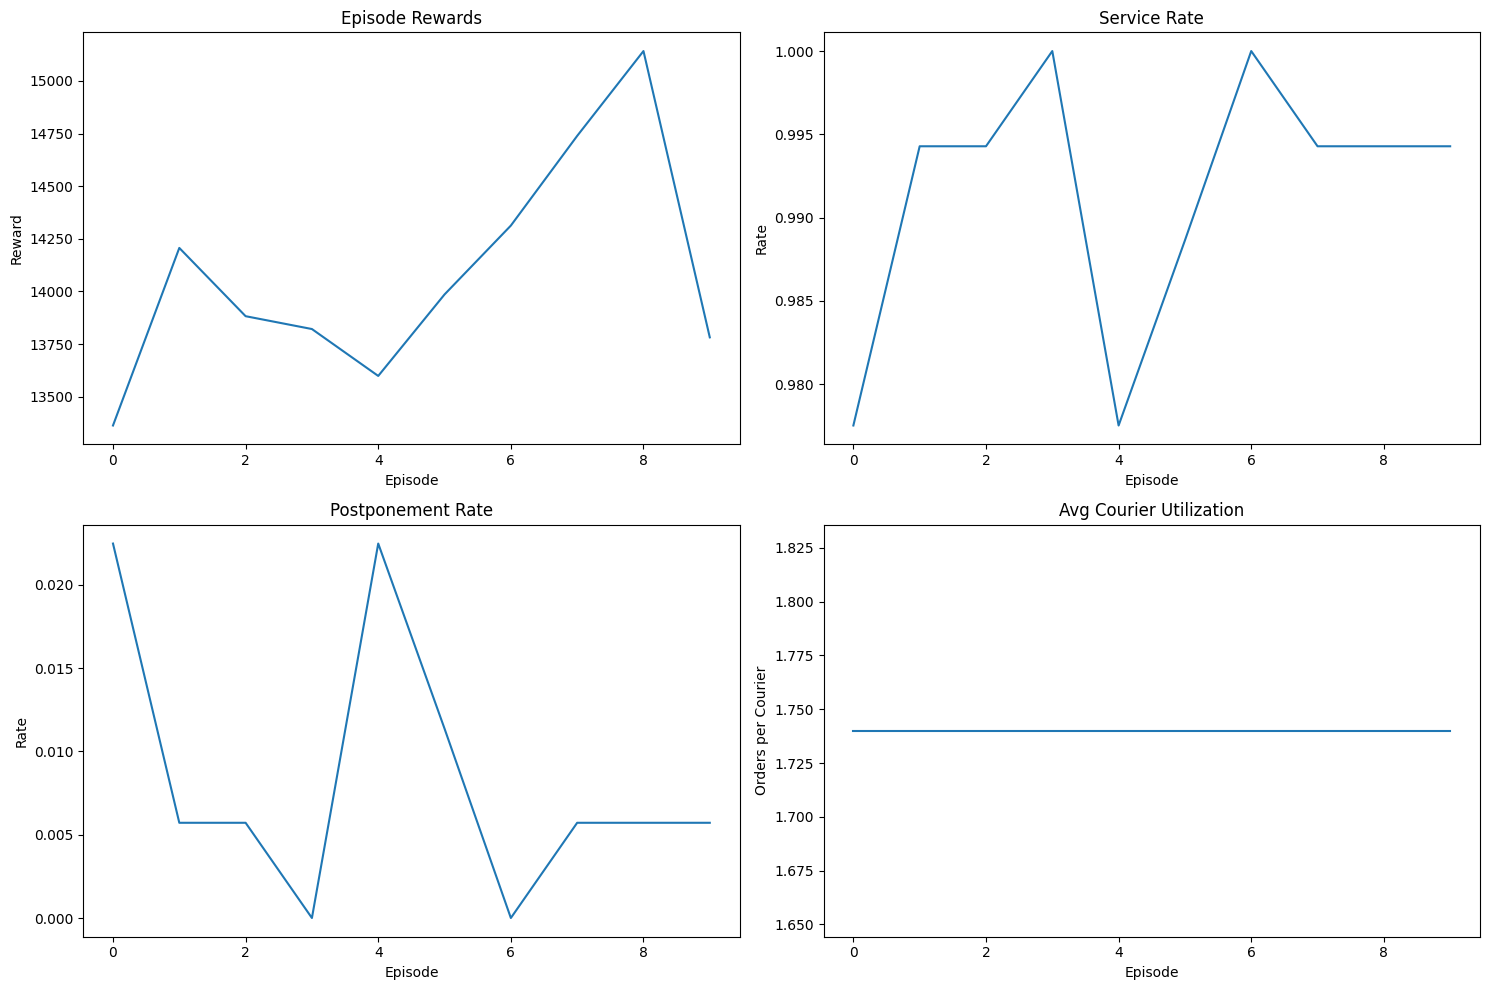

In [93]:
# Execute training
if __name__ == "__main__":
    print("Starting training...")
    agent, env, rewards_history, metrics = train_agent(episodes=10, batch_size=32)